# Full fledge neural net with hyperparameter and droput

In [3]:
import numpy as np 

In [4]:
class DeepNeuralNetwork:
    def __init__(self,input_size,output_size,hidden_size,epoches=1000,learning_rate=0.001,dropout=0.5,hidden_layers=2):
        self.input_size = input_size 
        self.output_size = output_size
        self.hidden_size = hidden_size 
        self.learning_rate = learning_rate 
        self.dropout = dropout 
        self.hidden_layers = hidden_layers 
        self.epoches = epoches

        self.hidden_weights = [np.random.randn(self.input_size,self.hidden_size)* np.square(2/self.input_size)]
        self.hidden_bias = [np.zeros((1,self.hidden_size))]
        
        self.Hidden_Gradient_weights = [np.zeros((self.input_size,self.hidden_size))]
        self.Hidden_Gradient_bias = [np.zeros((1,self.hidden_size))]

        for _ in range(self.hidden_layers): 
            self.hidden_weights.append(np.random.randn(self.hidden_size,self.hidden_size) * np.square(2/self.input_size))
            self.hidden_bias.append(np.zeros((1,self.hidden_size)))
            self.Hidden_Gradient_weights.append(np.zeros((self.hidden_size,self.hidden_size)))
            self.Hidden_Gradient_bias.append(np.zeros((1,self.hidden_size)))
         


        self.output_weight = np.random.randn(self.hidden_size,self.output_size)
        self.Output_Gradient_weights = np.zeros((self.hidden_size,self.output_size))
        self.output_bias = np.zeros((1,self.output_size))
        self.Output_Gradient_bias = np.zeros((1,self.output_size))


    def sigmoid(self,z):
        return (1/(1+np.exp(-z)))
    
    def derivative_sigmoid(self,z):
        s = self.sigmoid(z)
        return s * (1-s)
    
    def Relu(self,z):
        return np.maximum(0,z)

    def derivative_relu(self,z):
        return (z > 0 ).astype(float)
    
    def compute_loss(self,preds,Y):
        preds = np.clip(preds,1e-8,1-1e-8) 
        return -np.mean(Y*np.log(preds)+(1-Y)*np.log(1-preds)) 
    
    def Dropout(self,A):
        mask = np.random.rand(*A.shape) < self.dropout
        return (mask * A ) / self.dropout

    
    def ForwardPropagation(self,X):
        self.Activations = [X]
        self.hidden_Z = []

        for l in range(self.hidden_layers):
            Z = np.dot(self.Activations[l],self.hidden_weights[l]) + self.hidden_bias[l] 
            self.hidden_Z.append(Z)
            A = self.Relu(Z) 
            self.Activations.append(self.Dropout(A))

        self.output_Z = np.dot(self.Activations[-1],self.output_weight) + self.output_bias 
        self.output_A = self.sigmoid(self.output_Z) 
        return self.output_A

    def BackPropagation(self,X,Y):
        m = X.shape[0]
        alpha = 1e-8
        error = self.output_A - Y 
        Dwo = 1/m * np.dot(self.Activations[-1].T,error)
        Dbo = 1/m * np.sum(error,keepdims=True,axis=0) 

        G = self.Output_Gradient_weights + np.square(Dwo)
        self.Output_Gradient_weights = G 

        G = self.Output_Gradient_bias + np.square(Dbo)
        self.Output_Gradient_bias = G 


        self.output_weight =  self.output_weight - (self.learning_rate /  (self.Output_Gradient_weights + alpha)) * Dwo
        self.output_bias = self.output_bias - (self.learning_rate /  (self.Output_Gradient_bias + alpha)) * Dbo
        for l in reversed(range(self.hidden_layers)):
            
            da = np.dot(error,self.output_weight.T if l == self.hidden_layers-1 else self.hidden_weights[l+1].T)
            dz = da * self.derivative_relu(self.hidden_Z[l]) # final errors 
            dw = 1/m * np.dot(self.Activations[l].T,dz)
            db = 1/m * np.sum(dz,keepdims=True,axis=0)
            error = dz 

            G = self.Hidden_Gradient_weights[l] +  np.square(dw)
            self.Hidden_Gradient_weights[l] = G 
            G = self.Hidden_Gradient_bias[l] + np.square(db)
            self.Hidden_Gradient_bias[l] = G 

            self.hidden_weights[l] = self.hidden_weights[l] - self.learning_rate / np.sqrt(self.Hidden_Gradient_weights[l]+alpha) * dw 
            self.hidden_bias[l] = self.hidden_bias[l] - self.learning_rate / np.sqrt(self.Hidden_Gradient_bias[l]+alpha) * db  

    def fit(self,X,Y):
        Y = np.array(Y).reshape(-1,1)
        for epoch in range(self.epoches):
                preds_F = self.ForwardPropagation(X)
                loss = self.compute_loss(preds_F,Y)
                print(f"epoch : {epoch+1}, loss : {loss}")
                self.BackPropagation(X,Y)

    def predict(self,X):
        return (self.ForwardPropagation(X) > 0.5).astype(int)


In [5]:
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import pandas as pd 
dataset = pd.read_csv("../BankNote_Authentication.csv")
dataset.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [6]:
Y = np.array(dataset['class']).reshape(-1,1)
X = np.array(dataset.drop(columns=['class']))
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

print(Y_train.shape)

(1029, 1)


In [9]:
# X = np.array([[0,0],[0,1],[1,0],[1,1]])
# Y = np.array([0,0,0,1])
model = DeepNeuralNetwork(
    input_size=4,
    output_size=1,
    hidden_size=16,
    epoches=1000,
    learning_rate=0.001,
    dropout=0.8,
    hidden_layers=4
)

model.fit(X_train,Y_train)
preds = model.predict(X_test)

epoch : 1, loss : 0.9360051771934128
epoch : 2, loss : 0.9101914752367453
epoch : 3, loss : 0.9270095905568606
epoch : 4, loss : 0.889682918066547
epoch : 5, loss : 0.8568119345054153
epoch : 6, loss : 0.8777776457450067
epoch : 7, loss : 0.8929454044874003
epoch : 8, loss : 0.8731943406975908
epoch : 9, loss : 0.8402459383264033
epoch : 10, loss : 0.8335838556182874
epoch : 11, loss : 0.8642463300619395
epoch : 12, loss : 0.8357350750848817
epoch : 13, loss : 0.8257039181420649
epoch : 14, loss : 0.8306871472638974
epoch : 15, loss : 0.8408984995431141
epoch : 16, loss : 0.7835223766862123
epoch : 17, loss : 0.7999785626496767
epoch : 18, loss : 0.8146386405494963
epoch : 19, loss : 0.7926720015440032
epoch : 20, loss : 0.8190287838325742
epoch : 21, loss : 0.8020725880485338
epoch : 22, loss : 0.7790585021378248
epoch : 23, loss : 0.7838561544002728
epoch : 24, loss : 0.7960905940138663
epoch : 25, loss : 0.8259501936090766
epoch : 26, loss : 0.7740830990524643
epoch : 27, loss : 0.7

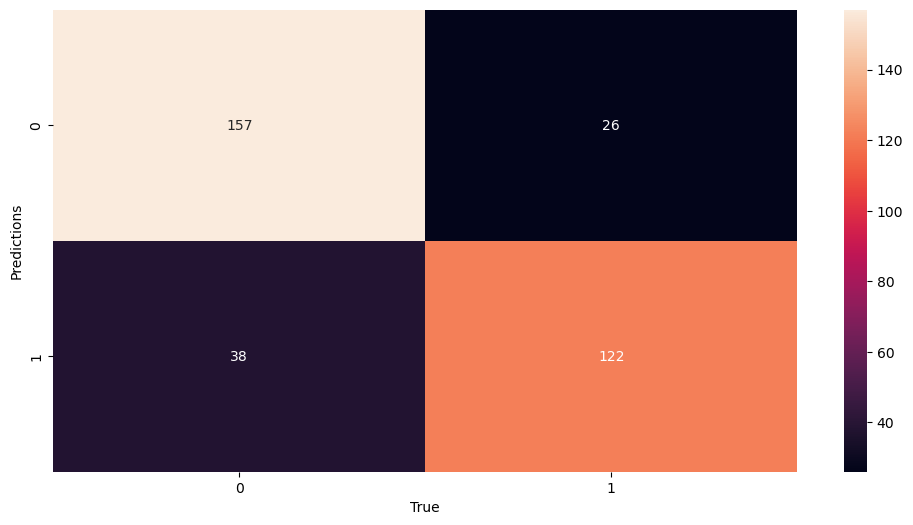

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       183
           1       0.82      0.76      0.79       160

    accuracy                           0.81       343
   macro avg       0.81      0.81      0.81       343
weighted avg       0.81      0.81      0.81       343



In [11]:
from sklearn.metrics import classification_report
cmf = confusion_matrix(Y_test,preds)

plt.figure(figsize=(12,6))
sns.heatmap(cmf,annot=True,fmt='d')
plt.xlabel("True")
plt.ylabel("Predictions")
plt.show()
print(classification_report(Y_test,preds))